In [22]:
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from nilearn.connectome import vec_to_sym_matrix, sym_matrix_to_vec
from nilearn.connectome import ConnectivityMeasure
from matplotlib import cm
from matplotlib.colors import Normalize

import sys
sys.path.append('../')
from PAINTeR import plot # in-house lib used for the RPN-signature


# Load behavioral data

In [23]:
# load data
df_bochum = pd.read_csv("../res/bochum_sample_excl.csv")
df_essen = pd.read_csv("../res/essen_sample_excl.csv")
df_szeged = pd.read_csv("../res/szeged_sample_excl.csv")
df_bochum['study'] = 'bochum'
df_essen['study'] = 'essen'
df_szeged['study'] = 'szeged'
df = pd.concat((df_bochum, df_essen, df_szeged), sort=False)
df = df.reset_index()
df

,index,Unnamed: 0,ID,Excluded,exclusion_crit,Male,day_menses,Age,height,weight,...,weight..kg.,psq_moderate,psq_minor,PSQ20,PSQI,MDT_log_geom,Pulse_MRI,Pulse_QST,BDI,PSQ20_essen
0,0,0,4,0.0,NaN,1.0,NaN,25.552361,175.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,1,6,0.0,NaN,1.0,NaN,33.453799,183.0,80.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,2,7,0.0,NaN,1.0,NaN,26.119097,186.0,92.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,3,8,0.0,NaN,1.0,NaN,25.445585,180.0,72.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,4,9,0.0,NaN,0.0,6.0,22.573580,176.0,70.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,14,14,22,0.0,NaN,1.0,NaN,24.000000,185.0,82.0,...,NaN,27.0,11.0,6.0,1.0,-1.259900,73.0,76.0,5.0,24.0
87,15,15,24,0.0,NaN,1.0,NaN,22.000000,183.0,83.0,...,NaN,28.0,16.0,9.0,1.0,-1.913513,85.0,86.0,0.0,25.0
88,16,16,25,0.0,NaN,1.0,NaN,22.000000,195.0,77.0,...,NaN,20.0,9.0,11.0,NaN,-1.581106,88.0,91.0,1.0,25.0
89,17,17,28,0.0,NaN,0.0,5.0,23.000000,162.0,59.0,...,NaN,34.0,18.0,43.0,2.0,-1.145363,78.0,89.0,7.0,37.0


# Compute connectivity

Region names:
 ['GlobSig' 'CER6_p' 'CER7ab' 'R_CERCR2_p' 'CER9_v' 'CER6_a' 'L_CERCR2_a'
 'CER9_d' 'CER9_m' 'CER7b_m' 'L_CERCR2_p' 'CER7b_l' 'N' 'CERCR1' 'CER6_d'
 'CER5' 'R_CERCR2_a' 'POsul_d' 'POsul_v' 'VMPFcor_p' 'R_MTgyr_a'
 'L_ANGgyr' 'L_MTgyr_p' 'L_MTgyr_a' 'DMPFC_ar' 'L_SFsul_a' 'DMPFcor_ac'
 'PCcor' 'POsul' 'L_IPlob' 'PGACcor' 'VMPFcor_a' 'PRC_d' 'SFgyr_ad'
 'L_IPlob.1' 'R_ANGgyr' 'PRC_v' 'R_MTgyr_p' 'PRC_d.1' 'R_MFgyr_a'
 'L_DVIS_v' 'SPlob' 'R_VLPFcor' 'FUSgyr_vl' 'R_IFsul' 'FP' 'R_DVIS_v'
 'L_FP_l' 'SPlob.1' 'L_MFgyr_pc' 'L_VLPFcor' 'OCCTgyr_l' 'ACcor_d'
 'L_MFgyr_pr' 'R_MFgyr_p' 'R_IPsul' 'L_IFsul' 'DVIS_s' 'FUSgyr_dl'
 'R_SFsul' 'R_IPlob' 'R_FP_l' 'R_PORB' 'DMPFcor_p' 'L_IPsul' 'L_MFgyr_a'
 'DVIS_vl' 'CAUDNH_NACC' 'COLsul' 'LORBgyr' 'ITgyr' 'STgyr_a' 'MORBgyr'
 'PINS_v' 'TP' 'HIPP' 'AMY' 'PIsul' 'CERVM' 'L_MOTnet_dl' 'MOTnet_am'
 'R_MOTnet_dl' 'MOTnet_m' 'MOTnet_ml' 'MOTnet_vl' 'MOTnet_l' 'l_PCsul'
 'CNGsul_p' 'PUT_p' 'AINS_pd' 'CAUDN_d' 'AINS_v' 'FEF' 'PCsul_d' 'IMsul'
 'ST

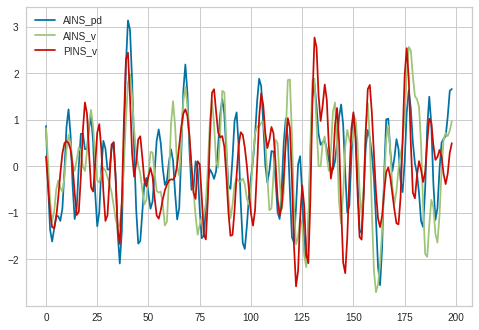

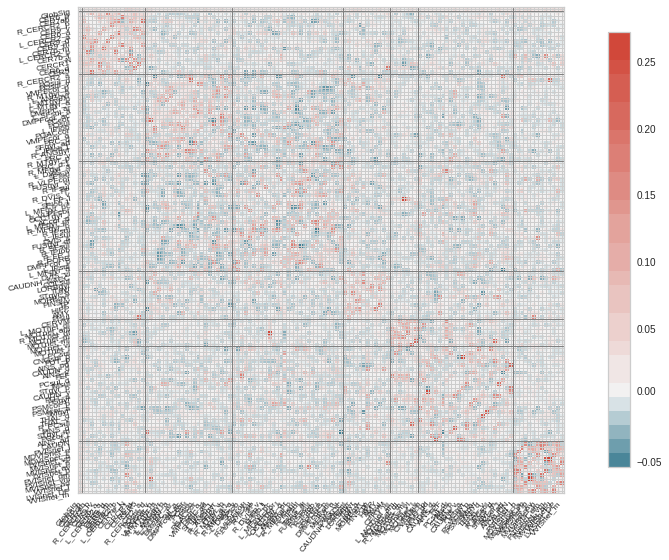

In [24]:
timeseries = []
perc_scrubbed = []
for i, f in enumerate(df['ts_file']):
    f = '..' + f.split('/..')[1]
    f_scrub = f.split('.tsv')[0] + '-scrubbed.tsv'

    ts = pd.read_csv(f_scrub).iloc[:, 1:]  # here we can omit global signal...

    fd_file = df["fd_file"].values[i]
    fd_file = '..' + fd_file.split('/..')[1]
    fd = pd.read_csv(fd_file).values.ravel().tolist()
    fd = [0] + fd

    perc_scrubbed.append(100 - 100 * len(ts.shape) / len(fd))
    timeseries.append(ts.values)

# double check visually
sub_idx = 10  # modify this for a different subject
# modify below for different regions (see the next cell for region names)
pd.DataFrame(timeseries[sub_idx], columns=ts.columns.values).loc[:, ['AINS_pd', 'AINS_v', 'PINS_v']].plot()
## Load region and module names for the MIST122 atlas
labels = ts.columns.values
l = pd.read_csv('../data/atlas_relabeled.tsv', sep="\t")
modules = np.insert(l['modules'].values, 0, "GlobSig")
print('Region names:\n', labels)
## Calculate functional connectivity as partial correlation
correlation_measure = ConnectivityMeasure(kind='partial correlation', vectorize=False)
X = correlation_measure.fit_transform(timeseries)  # these are the features
joblib.dump(X, "../res/multi-center/all_features.joblib")

# double-check the mean matrix visually
mat = correlation_measure.mean_
#mat=mat[1:, 1:] #fisrt row and column is global signal
mat[range(mat.shape[0]), range(mat.shape[0])] = 0  # zero diag
plot.plot_matrix(mat, labels, modules)

In [25]:
X.shape

(91, 123, 123)

# Load participant-level connectivity data

In [26]:
mc_model = pd.read_csv('../res/multi-center/finalized_model_connections.csv')
#mc_model = mc_model[mc_model['abs_multi-center']>0.07]
conns_mc_model = np.zeros((X.shape[0], len(mc_model)))
for idx, (i_a, i_b) in enumerate(zip(mc_model.idx_A, mc_model.idx_B)):
    conns_mc_model[:, idx] = X[:, i_a, i_b]
    #if mc_model.iloc[idx,:]['multi-center'] < 0:
    #    conns_mc_model[:, idx] *= -1
conns_mc_model = pd.DataFrame(conns_mc_model, columns=mc_model.connectivity)
conns_mc_model


connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
0,0.021891,0.124197,0.127759,-0.021352,0.145841,-0.064799,-0.006763,0.057262,-0.048813,-0.028449,...,0.081321,-0.046985,-0.016976,0.162298,0.075992,0.112617,-0.011008,-0.018719,-0.074869,-0.006091
1,0.015723,-0.128829,0.094542,0.125166,0.201690,-0.074666,0.017897,-0.086719,-0.122995,0.050970,...,0.033913,0.023110,-0.031482,-0.041393,0.042216,0.137049,-0.108424,-0.016450,-0.015471,0.032730
2,0.013114,-0.062290,-0.090155,0.052071,0.068738,0.030321,0.031548,0.089352,-0.032115,-0.026347,...,0.055872,-0.017286,0.022766,0.052997,-0.014386,0.104354,0.022060,0.069925,0.113806,-0.111940
3,0.020028,0.065334,-0.031791,0.147238,0.190687,0.042861,0.029229,0.056893,-0.048255,-0.086411,...,0.003797,0.066444,0.100155,0.101198,-0.015062,-0.022866,-0.129940,0.053899,-0.073163,0.060156
4,0.027947,-0.020950,-0.003799,0.133163,0.153021,-0.029537,0.018096,-0.028581,-0.038915,0.029342,...,0.057329,0.021621,-0.025921,-0.027753,0.061111,-0.010212,0.030001,-0.039720,-0.019237,0.064941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,0.031210,0.088623,0.011089,0.026238,0.210191,-0.017681,-0.073872,0.031895,-0.078204,0.022764,...,-0.011890,0.020761,-0.006920,0.006928,0.028016,0.040750,0.029395,-0.016146,-0.020249,0.095300
87,0.021306,0.104734,0.037766,0.173000,0.157848,-0.082971,-0.131150,-0.032904,0.017431,-0.108233,...,-0.090136,-0.047688,0.002433,0.040920,0.041044,0.042326,0.010826,0.023084,0.100832,-0.052292
88,0.014579,0.132763,-0.108385,0.099388,0.053617,0.046721,0.096082,-0.155134,-0.120663,0.104619,...,-0.181528,-0.020835,0.046505,-0.138580,0.013929,-0.049692,-0.033406,0.069901,0.094161,-0.025747
89,0.019275,0.059405,-0.146022,0.036162,0.247881,0.005831,-0.088877,-0.022490,0.169983,-0.258408,...,-0.048504,-0.016585,0.107030,-0.057102,0.093968,-0.005255,-0.034939,-0.075313,0.036747,-0.094788


In [27]:
#vars = df[['Male', 'Age', 'CDT_log_mean', 'WDT_log_mean', 'MDT_log_geom', 'CPT', 'HPT', 'MPT_log_geom', 't50', 'psq', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'anx_state', 'anx_trait', 'PSQ20', 'ads_k', 'Glx_mean', 'GABA_mean', 'meanFD', 'maxFD', 'medianFD', 'BP_MRI_sys', 'BP_MRI_dias', 'BP_QST_sys', 'BP_QST_dias' ]]

df2 = df.copy()
df2['nHPT'] = df.HPT * -1
df2['nMPT'] = df.MPT_log_geom * -1
df2['nt50'] = df.t50 * -1
df2['npsq'] = df.psq * -1
df2['nanx_state'] = df.anx_state * -1
df2['nanx_trait'] = df.anx_trait * -1
df2['study'] = df.study.astype('category').cat.codes

#vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'pcs_catastrophizing', 'pcs_rumination']]
#vars = df2[['CPT', 'nHPT', 'nMPT', 'npsq', 'nanx_state', 'nanx_trait']]
vars = df2[['CPT', 'nHPT', 'nMPT', 'nt50', 'npsq', 'nanx_state', 'nanx_trait', 'pcs_catastrophizing', 'pcs_rumination', 'PSQI', 'PSQ20', 'ads_k']]

vars.corrwith(df.mean_QST_pain_sensitivity)

CPT                    0.714782
nHPT                   0.769679
nMPT                   0.634185
nt50                   0.534950
npsq                   0.190144
nanx_state             0.202458
nanx_trait             0.204718
pcs_catastrophizing    0.134912
pcs_rumination         0.215321
PSQI                   0.296726
PSQ20                  0.308412
ads_k                  0.081807
dtype: float64

In [28]:
corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))

for i in range(vars.shape[1]):
    for j in range(conns_mc_model.shape[1]):
        mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
        corrmtx[i, j] = np.corrcoef(vars.values[mask,i], conns_mc_model.values[mask,j])[0,1]
corrmtx = pd.DataFrame(corrmtx, columns=conns_mc_model.columns, index=vars.columns)
corrmtx

connectivity,GlobSig - VMPFcor_p,CER6_p - MORBgyr,CER6_p - PSMcor_p,CER7ab - CAUDNH_NACC,R_CERCR2_p - R_CERCR2_a,R_CERCR2_p - STgyr_a,R_CERCR2_p - AINS_v,R_CERCR2_p - PVISnet_dm,L_CERCR2_a - R_MTgyr_a,CER9_d - L_MFgyr_pc,...,MOTnet_m - MVISnet_p,MOTnet_m - LVISnet_p,PUT_p - STgyr_p,AINS_pd - PUT_a,AINS_pd - MDVISnet_p,AINS_v - MVISnet_ad,FEF - IMsul,STgyr_p - LVISnet_DP,THAL_d - PCcor.1,THAL_v - PINS_d
CPT,0.218888,0.227387,-0.231473,0.310017,0.181493,-0.136003,-0.219108,0.308218,-0.088551,0.108076,...,-0.275131,0.174136,0.243219,-0.122858,-0.173764,-0.219074,0.275399,0.066448,0.176775,0.138239
nHPT,0.161564,0.291471,-0.254461,0.347498,0.252683,-0.232522,-0.168474,0.238095,-0.113355,0.244624,...,-0.114626,0.298346,0.276420,-0.215576,-0.212870,-0.228620,0.267165,0.283450,0.274513,0.187179
nMPT,0.301945,0.136736,-0.201422,0.027588,0.164708,-0.118144,-0.093630,-0.117084,-0.064367,0.161176,...,-0.137282,0.439023,0.105791,-0.261143,-0.198211,-0.171467,0.209269,0.092689,0.348656,0.248983
nt50,0.009989,0.180914,-0.319194,0.069174,0.084996,0.015976,-0.153033,0.072413,-0.007896,-0.018929,...,-0.453834,0.408920,0.224664,0.078798,-0.138484,-0.324741,0.107535,-0.082198,0.286457,0.286114
npsq,0.361906,0.064650,-0.009865,0.077909,0.375797,0.105488,0.002857,-0.178004,0.109571,-0.073121,...,0.048563,0.282711,-0.116082,-0.163604,-0.022690,-0.083695,0.232201,0.003573,0.051586,-0.010707
nanx_state,0.394896,0.030007,-0.026690,0.001207,0.431048,0.144962,0.014017,-0.173659,0.055982,-0.042780,...,0.053913,0.260548,-0.056158,-0.145027,-0.046263,-0.179421,0.239972,-0.046450,0.139687,-0.035873
nanx_trait,0.385377,0.002733,-0.042216,0.007472,0.413689,0.153239,-0.005170,-0.174068,0.048025,-0.017537,...,0.008707,0.278432,-0.055220,-0.171715,-0.080542,-0.172157,0.250685,-0.013330,0.160756,-0.021476
pcs_catastrophizing,0.005730,0.006787,-0.111155,-0.052501,0.040152,0.024004,-0.043877,0.197777,-0.023237,-0.026773,...,0.091981,0.032641,0.047185,0.161553,0.007177,0.000470,0.036557,0.087098,0.010068,-0.000595
pcs_rumination,0.159344,0.100928,-0.025577,-0.138164,0.101819,-0.262166,-0.017303,0.229777,-0.308559,0.308589,...,0.105289,-0.075319,0.031824,0.159639,-0.137901,-0.249635,0.316611,-0.046288,0.109181,0.025208
PSQI,-0.080914,0.032809,-0.190889,-0.033573,0.221576,-0.027921,-0.154723,0.241252,-0.037023,0.037168,...,0.026482,0.352548,-0.059845,-0.030204,-0.263429,-0.025996,-0.095407,0.013938,0.147407,0.015165


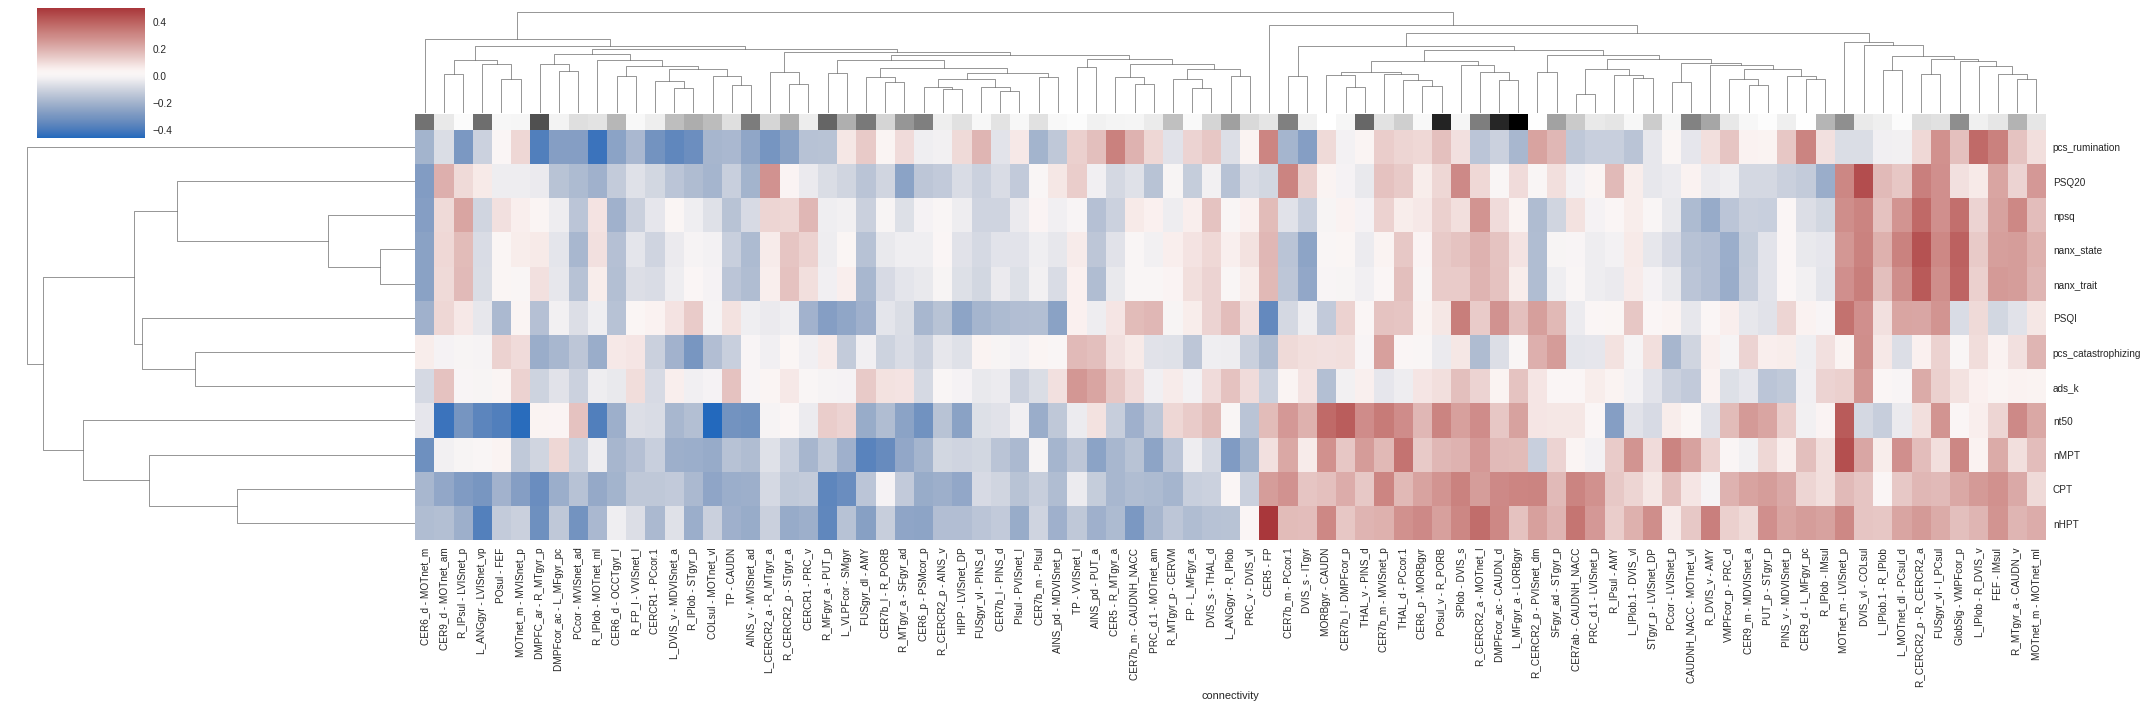

In [29]:
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='average', cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [30]:
fig.savefig('../res/multi-center/cluster_map.pdf')

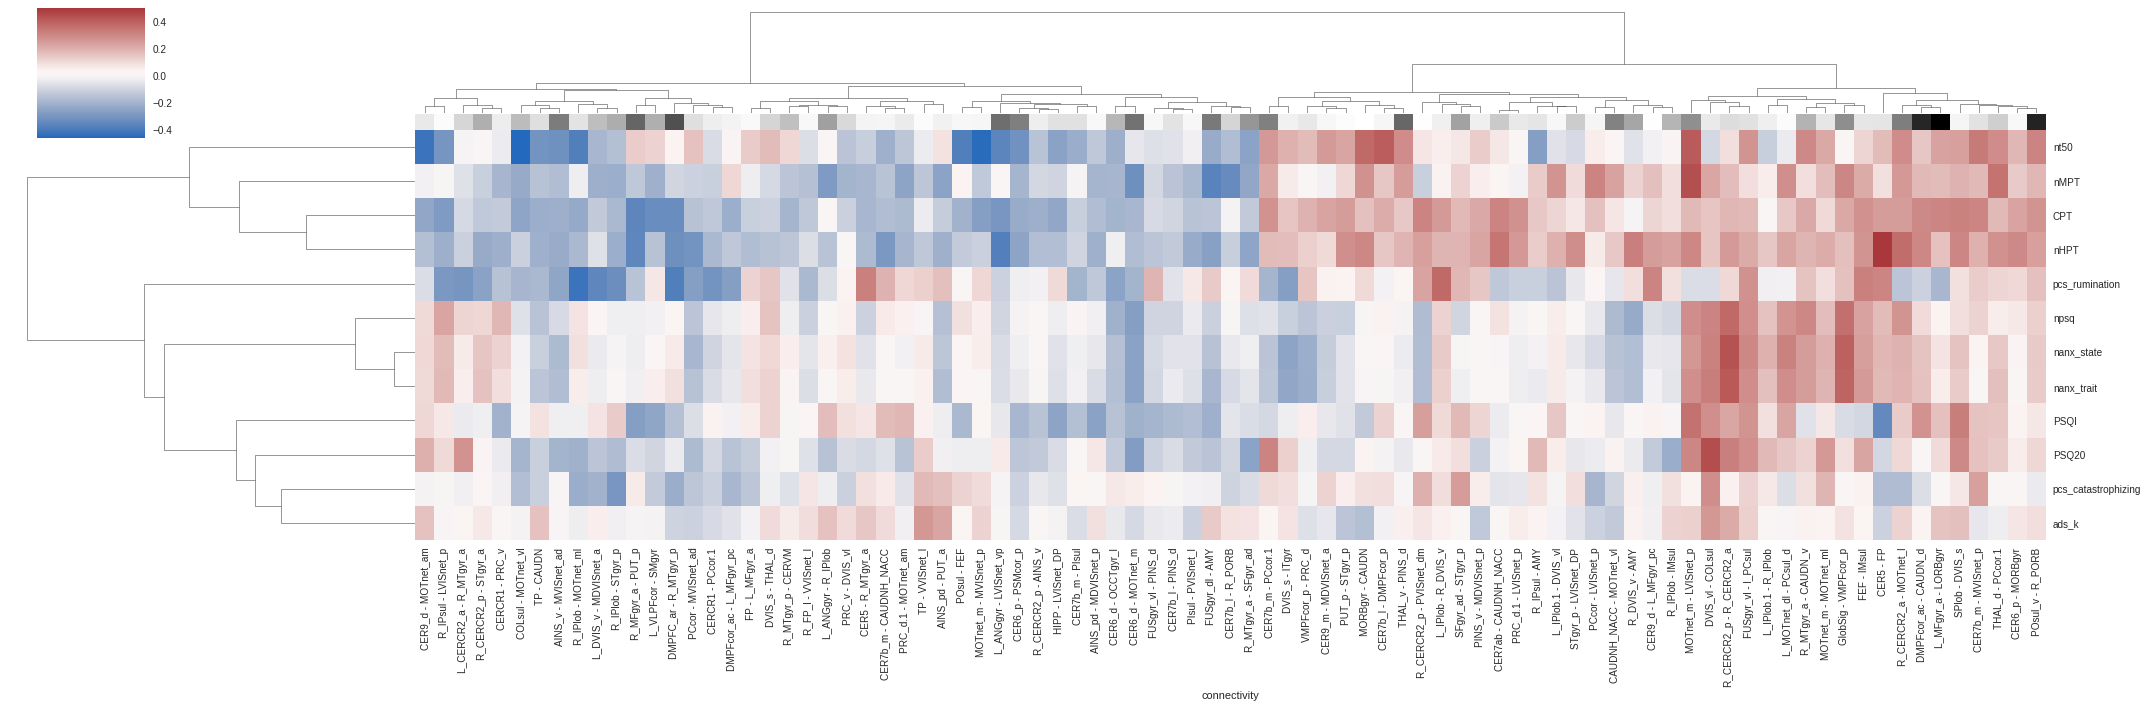

In [31]:
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='ward', cmap="vlag", figsize=(30,10), col_colors=cm.binary(norm(mc_model['abs_multi-center'])))

In [32]:
fig.savefig('../res/multi-center/cluster_map2.pdf')

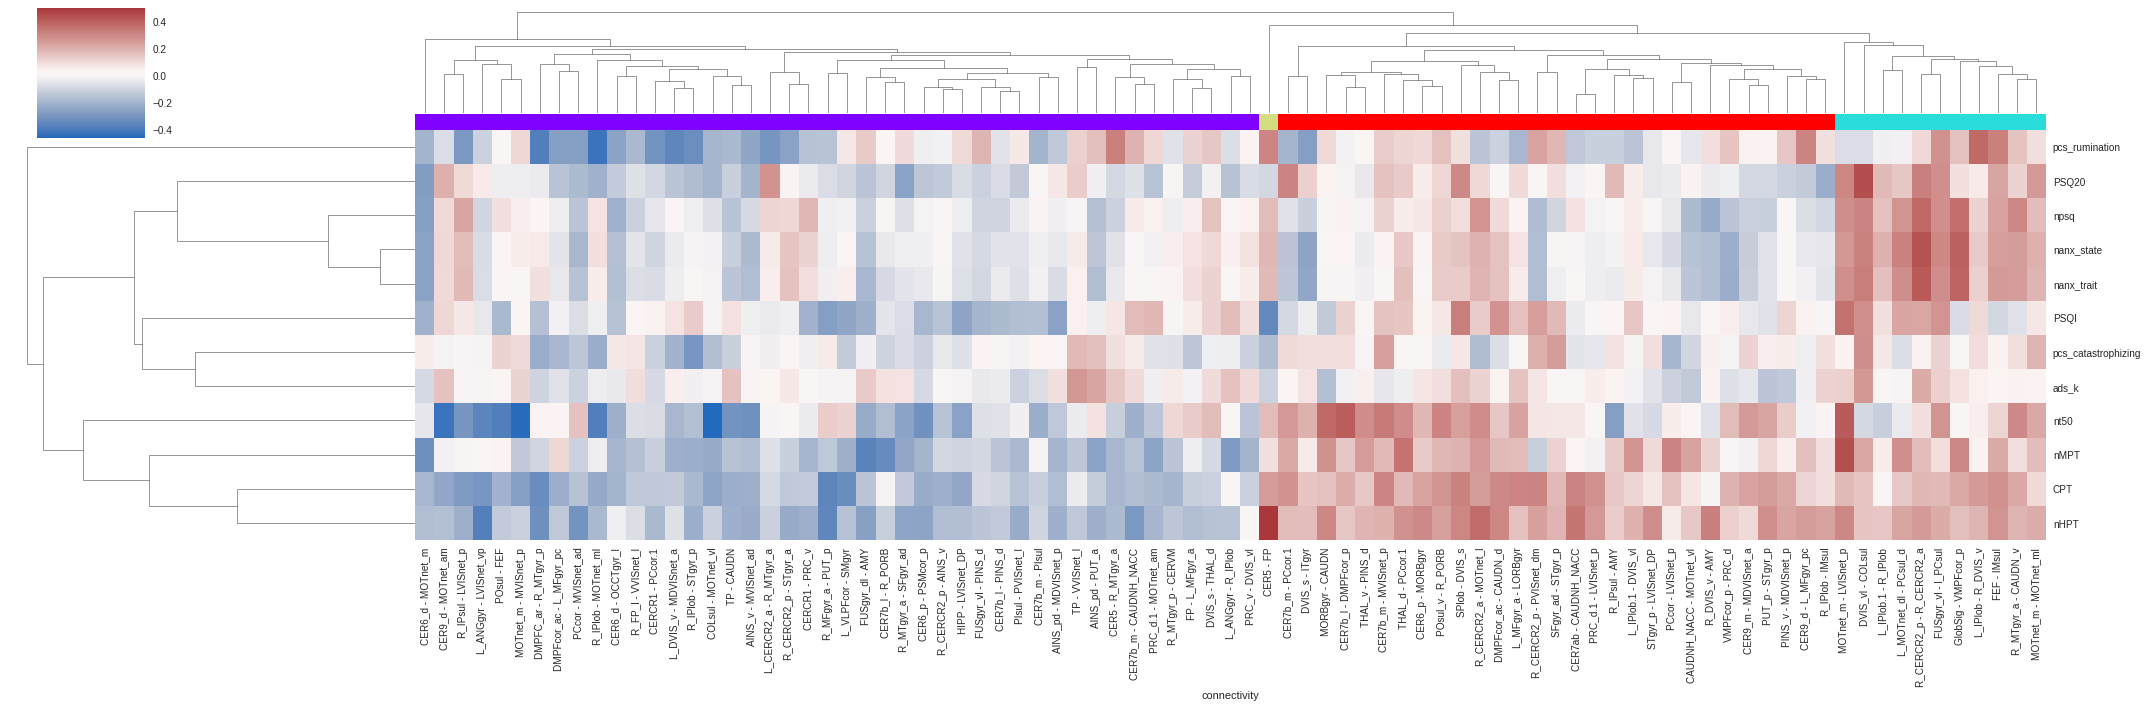

In [40]:
from sklearn.cluster import AgglomerativeClustering, KMeans
norm = Normalize()
fig = sns.clustermap(corrmtx.dropna(), method='average', metric='euclidean', cmap="vlag", figsize=(30,10), col_colors=cm.rainbow(norm(AgglomerativeClustering(n_clusters=4, linkage="average", affinity='euclidean').fit(corrmtx.dropna().T).labels_)))

In [54]:
from scipy.cluster.hierarchy import dendrogram

def linkage_matrix(model):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)
    return linkage_matrix

def plot_dendrogram(model, **kwargs):
    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix(model), **kwargs)

2 clust:  p = 0.002


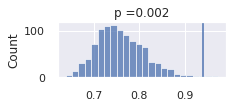

3 clust:  p = 0.006


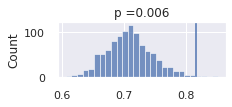

4 clust:  p = 0.03


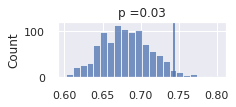

5 clust:  p = 0.131


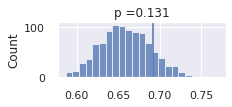

6 clust:  p = 0.278


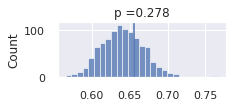

7 clust:  p = 0.393


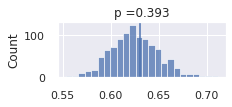

In [117]:
from joblib import Parallel, delayed

linkage = 'average'
affinity = 'euclidean'

nperm = 1000
n_jobs=-1
depth = 6 #must be greater than 1
act_height = 0.744
random_state = 42

# Actual data:
# setting distance_threshold=0 ensures we compute the full tree.
act_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, affinity=affinity)
act_model = act_model.fit(corrmtx.T)
act_lm = linkage_matrix(act_model)

def workhorse(seed):
    _rng = np.random.default_rng()
    perm_corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))
    for i in range(vars.shape[1]):
        for j in range(conns_mc_model.shape[1]):
            mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
            perm_corrmtx[i, j] = np.corrcoef(_rng.permutation(vars.values[mask,i]), conns_mc_model.values[mask,j])[0,1]
    # cluster
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage=linkage, affinity=affinity).fit(perm_corrmtx.T)
    lm = linkage_matrix(model)
    return lm[-(depth):,2]

rng = np.random.default_rng()
random_sates = rng.integers(np.iinfo(np.int32).max, size=nperm)
heights = np.array(Parallel(n_jobs=n_jobs)(delayed(workhorse)(seed) for seed in random_sates))

#results
sns.set(rc={"figure.figsize":(3, 1)})
for i in range(heights.shape[1]):
        p = np.sum(heights[:,-(i+1)] > act_lm[-(i+1),2])/nperm
        print(i+2, 'clust:  p =', p)
        sns.histplot(heights[:,-(i+1)])
        plt.axvline(act_lm[-(i+1),2])
        plt.title('p =' + str(p))
        plt.show()


0.129

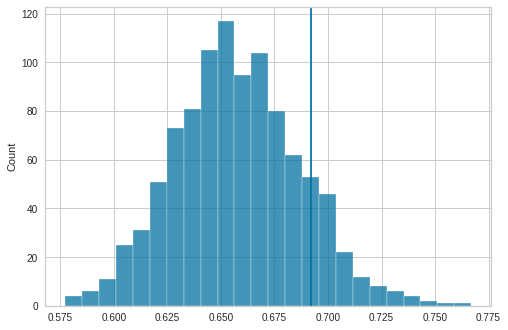

In [90]:
nperm = 1000
clust_num = 10
act_height = 0.692

# Actual data:
# setting distance_threshold=0 ensures we compute the full tree.
act_model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')
act_model = act_model.fit(corrmtx.T)
act_lm = linkage_matrix(act_model)

for p_i in range(nperm):
    # shuffle correlations in each column

    perm_corrmtx = np.zeros((vars.shape[1], conns_mc_model.shape[1]))

    for i in range(vars.shape[1]):
        for j in range(conns_mc_model.shape[1]):
            mask = ~np.isnan(vars.values[:,i]) & ~np.isnan(conns_mc_model.values[:,j])
            perm_corrmtx[i, j] = np.corrcoef(np.random.permutation(vars.values[mask,i]), conns_mc_model.values[mask,j])[0,1]
    #perm_corrmtx = pd.DataFrame(perm_corrmtx, columns=conns_mc_model.columns, index=vars.columns)

    # cluster
    model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average', affinity='euclidean').fit(perm_corrmtx.T)
    lm = linkage_matrix(model)
    heights[p_i] = lm[-(clust_num-1),2]

sns.histplot(heights)
plt.axvline(act_height)

np.sum(heights>act_height)/nperm


In [63]:
# Actual data:
# setting distance_threshold=0 ensures we compute the full tree.
model = AgglomerativeClustering(distance_threshold=0, n_clusters=None, linkage='average')
model = model.fit(corrmtx.T)
linkage_matrix(model)

array([[ 12.        ,  30.        ,   0.17614696,   2.        ],
       [ 54.        ,  60.        ,   0.20882229,   2.        ],
       [ 41.        ,  51.        ,   0.22401321,   2.        ],
       [ 55.        ,  84.        ,   0.23001001,   2.        ],
       [  1.        ,  76.        ,   0.23799887,   2.        ],
       [ 35.        ,  87.        ,   0.24311566,   3.        ],
       [ 66.        ,  86.        ,   0.24423881,   3.        ],
       [ 74.        ,  80.        ,   0.24807841,   2.        ],
       [ 13.        ,  48.        ,   0.25241449,   2.        ],
       [ 24.        ,  52.        ,   0.26345659,   2.        ],
       [ 14.        ,  79.        ,   0.26660216,   2.        ],
       [  8.        ,  83.        ,   0.2671191 ,   2.        ],
       [ 50.        ,  57.        ,   0.27088723,   2.        ],
       [ 17.        ,  68.        ,   0.28978615,   2.        ],
       [ 20.        ,  82.        ,   0.29370684,   2.        ],
       [ 61.        ,  88

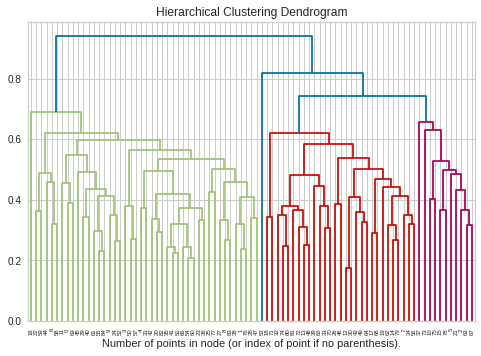

In [64]:

plt.title("Hierarchical Clustering Dendrogram")
# plot the top three levels of the dendrogram
plot_dendrogram(model, color_threshold=0.744)
plt.xlabel("Number of points in node (or index of point if no parenthesis).")
plt.show()

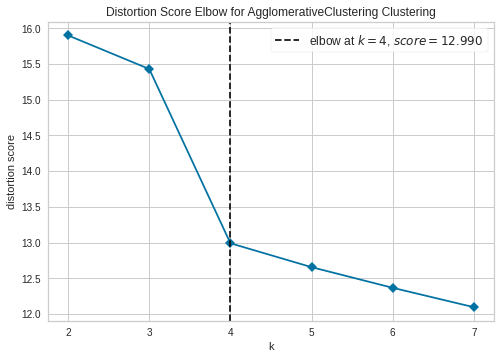

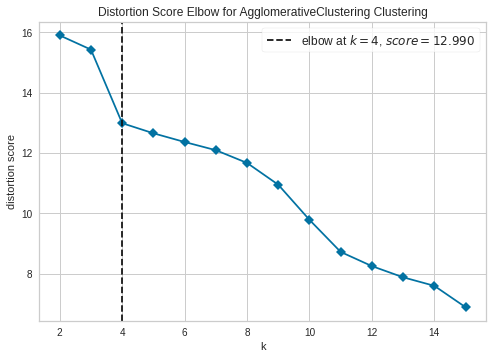

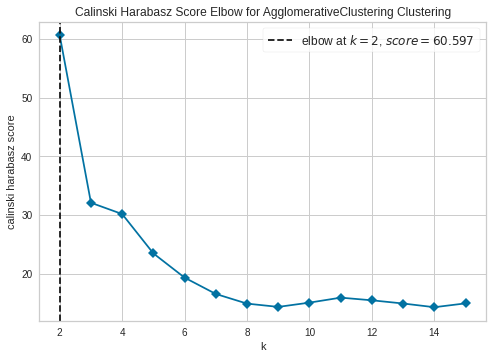

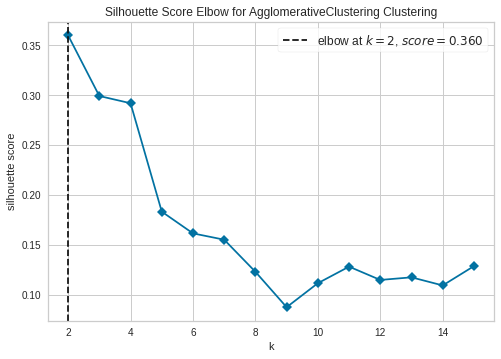

<AxesSubplot:title={'center':'Silhouette Score Elbow for AgglomerativeClustering Clustering'}, xlabel='k', ylabel='silhouette score'>

In [39]:
# Import ElbowVisualizer
from yellowbrick.cluster import KElbowVisualizer
model = AgglomerativeClustering(linkage='average', affinity='euclidean')
# k is range of number of clusters.
kmax = 16 #corrmtx.shape[1]

visualizer = KElbowVisualizer(model, k=(2,8), timings= False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False) # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, metric='calinski_harabasz') # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()        # Finalize and render figure

visualizer = KElbowVisualizer(model, k=(2,kmax), timings= False, metric='silhouette') # silhouette, calinski_harabasz, # corrmtx.shape[1]
visualizer.fit(corrmtx.T)        # Fit data to visualizer
visualizer.show()

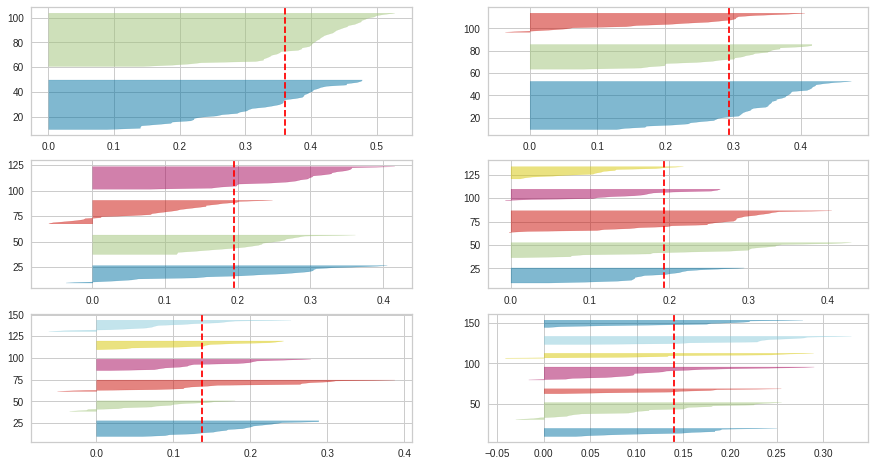

In [37]:
from sklearn import datasets
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from yellowbrick.cluster import SilhouetteVisualizer


fig, ax = plt.subplots(3, 2, figsize=(15,8))
for i in [2, 3, 4, 5, 6, 7]:
    '''
    Create KMeans instance for different number of clusters
    '''
    km = KMeans(n_clusters=i, init='k-means++', n_init=10, max_iter=100, random_state=None)
    q, mod = divmod(i, 2)
    '''
    Create SilhouetteVisualizer instance with KMeans instance
    Fit the visualizer
    '''
    visualizer = SilhouetteVisualizer(km, colors='yellowbrick', ax=ax[q-1][mod])
    visualizer.fit(corrmtx.T)

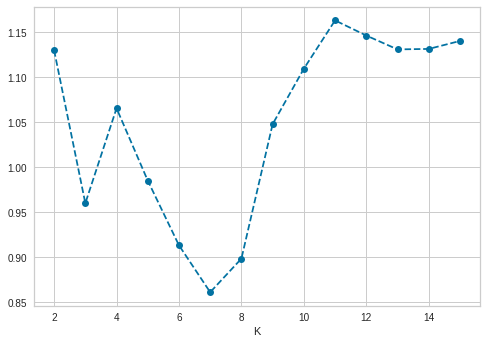

In [38]:
from sklearn.metrics import davies_bouldin_score
def get_kmeans_score(data, center):
    '''
    returns the kmeans score regarding Davies Bouldin for points to centers
    INPUT:
        data - the dataset you want to fit kmeans to
        center - the number of centers you want (the k value)
    OUTPUT:
        score - the Davies Bouldin score for the kmeans model fit to the data
    '''
    #instantiate kmeans
    kmeans = AgglomerativeClustering(n_clusters=center, linkage='average', affinity='euclidean')# Then fit the model to your data using the fit method
    model = kmeans.fit_predict(data)

    # Calculate Davies Bouldin scorescore = davies_bouldin_score(cluster_df, model)
    score = davies_bouldin_score(data, model)

    return score

scores = []

centers = list(range(2,16))
for center in centers:
    scores.append(get_kmeans_score(corrmtx.T, center))

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');